# Introduction to Reinforcement Learning: Cart Pole Demo

[![Open In Colab <](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/ShawnHymel/reinforcement-learning-demos/blob/main/rl-demo-cartpole.ipynb)

In this tutorial, we will tackle the popular "cart pole" problem. We use a simple virtual environment that consists of a cart that can only move in two directions: left and right. A pole is attached to the cart and is allowed to freely rotate around the cart on some axis perpendicular to the line of cart movement. The pole starts pointing up. Your job is to keep the pole in this "up" position by only moving the cart. Think of it like trying to balance a pole in your hand by only moving yoru hand left and right.

The action space is a discrete set:

 * move cart left
 * move cart right

 You can choose either one of these actions at each time step, and note there is no "stay still" option.

 The observation space is four continuous numerical values:

 0. Cart position: [-4.8, 4.8]
 1. Cart velocity: [-Inf, Inf]
 2. Pole angle: [-0.418 rad, 0.418 rad]
 3. Pole angular velocity [-Inf, Inf]

If the pole passes one of the angular extents (-4.18 rad or +4.18 rad), the simulation will end, and you will need to reset the environmnet.

You can read about the *gymnasium* implementation of cartpole [here](https://gymnasium.farama.org/environments/classic_control/cart_pole/).

This tutorial uses the *Deep Q Network* (DQN) algorithm to learn a policy that keeps the pole vertical. You can read about the Stable Baselines3 implementation and usage of DQN [here](https://stable-baselines.readthedocs.io/en/master/modules/dqn.html).

In [ ]:
!python -m pip install gymnasium==0.28.1
!python -m pip install stable-baselines3[extra]==2.0.0a1

In [1]:
import gymnasium as gym
import stable_baselines3 as sb3
import matplotlib.pyplot as plt
import cv2

# Check versions
print(f"gym version: {gym.__version__}")
print(f"cv2 version: {cv2.__version__}")

gym version: 0.28.1
cv2 version: 4.12.0


In [2]:
# Create the environment
# https://gymnasium.farama.org/api/env/
env = gym.make('CartPole-v1', render_mode='rgb_array')

In [3]:
# Reset the cart pole environment
# https://gymnasium.farama.org/environments/classic_control/cart_pole/
obs, info = env.reset()
print(obs)
print(info)

[-0.02477526 -0.00340425 -0.04556893  0.02698754]
{}


/opt/homebrew/Caskroom/miniforge/base/envs/rl_env/lib/python3.11/site-packages/pygame/pkgdata.py:25: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import resource_stream, resource_exists


(400, 600, 3)


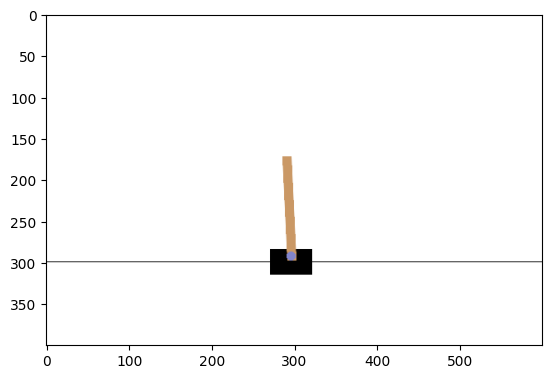

In [4]:
# Render the environment (render is not the observation!)
frame = env.render()
print(frame.shape)
plt.imshow(frame)

In [5]:
# View environment's action and observation spaces
# https://gymnasium.farama.org/api/spaces/fundamental/
print(f"Observation space: {env.observation_space}")
print(f"Action space: {env.action_space}")
print(f"Random observation: {env.observation_space.sample()}")
print(f"Random action: {env.action_space.sample()}")

Observation space: Box([-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38], (4,), float32)
Action space: Discrete(2)
Random observation: [-4.0284524e+00  1.8790375e+38 -1.6238421e-01  9.8040392e+37]
Random action: 0


[-0.02484334 -0.19784409 -0.04502917  0.3049519 ]
1.0
False


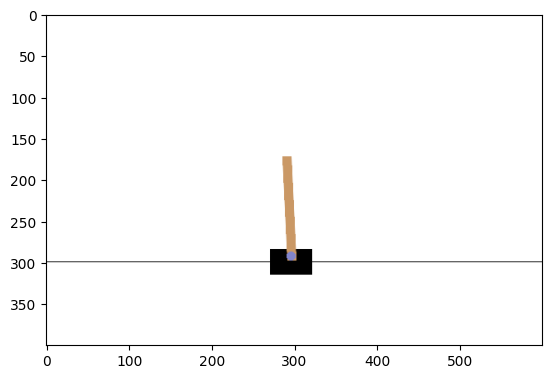

In [6]:
# Run a few times to see the pole fall
obs, reward, terminated, truncated, info = env.step(0)
print(obs)
print(reward)
print(terminated)
frame = env.render()
plt.imshow(frame)

In [7]:
# Function that tests the model in the given environment
def test_model(env, model, video=None, msg=None):

    # Reset environment
    obs, info = env.reset()
    frame = env.render()
    ep_len = 0
    ep_rew = 0

    # Run episode until complete
    while True:

        # Provide observation to policy to predict the next action
        action, _ = model.predict(obs)

        # Perform action, update total reward
        obs, reward, terminated, truncated, info = env.step(action)
        ep_rew += reward

        # Record frame to video
        if video:
            frame = env.render()
            frame = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
            frame = cv2.putText(
                frame,                    # Image
                msg,                      # Text to add
                (10, 25),                 # Origin of text in image
                cv2.FONT_HERSHEY_SIMPLEX, # Font
                1,                        # Font scale
                (0, 0, 0,),               # Color
                2,                        # Thickness
                cv2.LINE_AA               # Line type
            )
            video.write(frame)

        # Increase step counter
        ep_len += 1

        # Check to see if episode has ended
        if terminated or truncated:
            return ep_len, ep_rew

In [8]:
# Model that just predicts random actions
class DummyModel():

    # Save environment
    def __init__(self, env):
        self.env = env

    # Always output random action regardless of observation
    def predict(self, obs):
        action = self.env.action_space.sample()
        return action, None

In [9]:
# Recorder settings
FPS = 30
FOURCC = cv2.VideoWriter.fourcc('m', 'p', '4', 'v')
VIDEO_FILENAME = "1-random.mp4"

# Use frame from environment to compute resolution
width = frame.shape[1]
height = frame.shape[0]

# Create recorder
video = cv2.VideoWriter(VIDEO_FILENAME, FOURCC, FPS, (width, height))

# Try running a few episodes with the environment and random actions
dummy_model = DummyModel(env)
for ep in range(5):
    ep_len, ep_rew = test_model(env, dummy_model, video, f"Random, episode {ep}")
    print(f"Episode {ep} | length: {ep_len}, reward: {ep_rew}")

# Close the video writer
video.release()

Episode 0 | length: 33, reward: 33.0
Episode 1 | length: 21, reward: 21.0
Episode 2 | length: 10, reward: 10.0
Episode 3 | length: 20, reward: 20.0
Episode 4 | length: 46, reward: 46.0


In [10]:
# Initialize model
# DQN docs: https://stable-baselines3.readthedocs.io/en/master/modules/dqn.html
# Policy networks: https://stable-baselines.readthedocs.io/en/master/modules/policies.html
# Hyperparameters from: https://github.com/DLR-RM/stable-baselines3/issues/526#issuecomment-891153610
model = sb3.DQN(
    'MlpPolicy',
    env,
    learning_rate=0.0001,       # Learning rate of neural network (default: 0.0001)
    buffer_size=1000000,        # Size of the replay buffer (default: 1000000)
    learning_starts=1000,       # Number of steps to take before learning (default: 50000)
    batch_size=32,              # Minibatch size for each gradient update (default: 32)
    gamma=0.99,                 # Discount factor (default: 0.99)
    train_freq=256,             # Number of steps to take before update (default: 4)
    gradient_steps=128,         # Number of gradient steps after each rollout (default: 1)
    target_update_interval=10,  # Number of steps to take before target network update (default: 10000)
    policy_kwargs={'net_arch': [256, 256]}, # 2 hidden layers, 1 output layer (default: [64, 64])
    verbose=0                   # Print training metrics (default: 0)
)

In [11]:
# Training and testing hyperparameters
NUM_ROUNDS = 20
NUM_TRAINING_STEPS_PER_ROUND = 5000
NUM_TESTS_PER_ROUND = 100
MODEL_FILENAME_BASE = "cartpole-dqn"
VIDEO_FILENAME = "2-training.mp4"

# Create recorder
video = cv2.VideoWriter(VIDEO_FILENAME, FOURCC, FPS, (width, height))

# Train and test the model for a number of rounds
avg_ep_lens = []
avg_ep_rews = []
for rnd in range(NUM_ROUNDS):

    # Train the model
    model.learn(total_timesteps=NUM_TRAINING_STEPS_PER_ROUND)

    # Save the model
    model.save(f"{MODEL_FILENAME_BASE}_{rnd}")

    # Test the model in several episodes
    avg_ep_len = 0
    avg_ep_rew = 0
    for ep in range(NUM_TESTS_PER_ROUND):

        # Only record the first test
        if ep == 0:
            ep_len, ep_rew = test_model(env, model, video, f"Round {rnd}")
        else:
            ep_len, ep_rew = test_model(env, model)

        # Accumulate average length and reward
        avg_ep_len += ep_len
        avg_ep_rew += ep_rew

    # Record and dieplay average episode length and reward
    avg_ep_len /= NUM_TESTS_PER_ROUND
    avg_ep_lens.append(avg_ep_len)
    avg_ep_rew /= NUM_TESTS_PER_ROUND
    avg_ep_rews.append(avg_ep_rew)
    print(f"Round {rnd} | average test length: {avg_ep_len}, average test reward: {avg_ep_rew}")

# Close the video writer
video.release()

Round 0 | average test length: 230.65, average test reward: 230.65
Round 1 | average test length: 266.99, average test reward: 266.99
Round 2 | average test length: 204.11, average test reward: 204.11
Round 3 | average test length: 132.77, average test reward: 132.77
Round 4 | average test length: 185.48, average test reward: 185.48
Round 5 | average test length: 153.1, average test reward: 153.1
Round 6 | average test length: 183.56, average test reward: 183.56
Round 7 | average test length: 165.93, average test reward: 165.93
Round 8 | average test length: 174.24, average test reward: 174.24
Round 9 | average test length: 197.91, average test reward: 197.91
Round 10 | average test length: 218.05, average test reward: 218.05
Round 11 | average test length: 209.44, average test reward: 209.44
Round 12 | average test length: 187.66, average test reward: 187.66
Round 13 | average test length: 186.58, average test reward: 186.58
Round 14 | average test length: 255.11, average test reward:

Text(0.5, 23.52222222222222, 'Round')

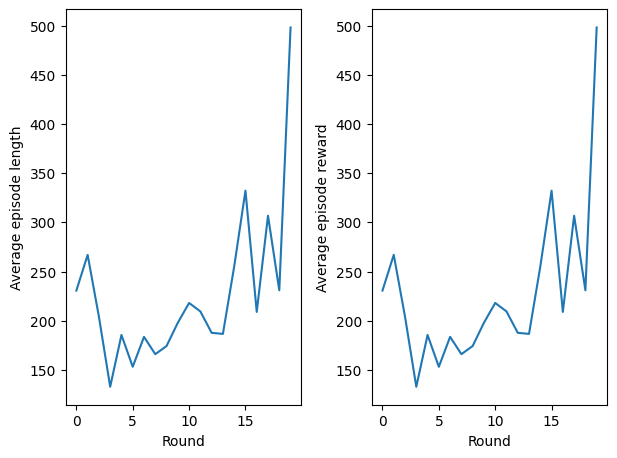

In [12]:
# Plot average test episode lengths and rewards for each round
fig, axs = plt.subplots(1, 2)
fig.tight_layout(pad=2.0)
axs[0].plot(avg_ep_lens)
axs[0].set_ylabel("Average episode length")
axs[0].set_xlabel("Round")
axs[1].plot(avg_ep_rews)
axs[1].set_ylabel("Average episode reward")
axs[1].set_xlabel("Round")

In [13]:
# Model and video settings
MODEL_FILENAME = "cartpole-dqn_19"
VIDEO_FILENAME = "3-testing.mp4"

# Load the model
model = sb3.DQN.load(MODEL_FILENAME)

# Create recorder
video = cv2.VideoWriter(VIDEO_FILENAME, FOURCC, FPS, (width, height))

# Test the model
ep_len, ep_rew = test_model(env, model, video, MODEL_FILENAME)
print(f"Episode length: {ep_len}, reward: {ep_rew}")

# Close the video writer
video.release()

Episode length: 500, reward: 500.0


In [14]:
# We're done with the environment
env.close()